In [36]:
!pip install shap

     |████████████████████████████████| 453 kB 1.0 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 4.4 MB/s eta 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import plot_partial_dependence

ImportError: cannot import name 'plot_partial_dependence' from 'sklearn.inspection' (/Users/ire/opt/anaconda3/lib/python3.8/site-packages/sklearn/inspection/__init__.py)

In [2]:
df=pd.read_csv('star_classification.csv')
#feature selection
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','spec_obj_ID','plate','MJD','fiber_ID'], axis='columns')

#cleaning the data
df = df[(df['u'] >= 0)]
#df = df[(df['g'] >= 0)]
#df = df[(df['z'] >= 0)]

print(df.describe())
print(df.head(10))

                  u             g             r             i             z  \
count  99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean      22.080679     20.631583     19.645777     19.084865     18.768988   
std        2.251068      2.037384      1.854763      1.757900      1.765982   
min       10.996230     10.498200      9.822070      9.469903      9.612333   
25%       20.352410     18.965240     18.135795     17.732280     17.460830   
50%       22.179140     21.099930     20.125310     19.405150     19.004600   
75%       23.687480     22.123775     21.044790     20.396510     19.921120   
max       32.781390     31.602240     29.571860     32.141470     29.383740   

           redshift  
count  99999.000000  
mean       0.576667  
std        0.730709  
min       -0.009971  
25%        0.054522  
50%        0.424176  
75%        0.704172  
max        7.011245  
          u         g         r         i         z   class  redshift
0  23.87882  22.2753

In [3]:
#turning the Class values into categorical data
df=df.rename(columns = {'class':'Class'})
df.Class = df.Class.astype('category')
cat_columns = df.select_dtypes(['category']).columns
cat_columns
df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)

In [4]:
# raw data Random Forest
## train test split
X = df.drop('Class',axis='columns')
y = np.array(df['Class'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

#array dimensions
y_train = y_train.transpose()
y_test = y_test.transpose()

#random forest
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_pred, y_test))
print(classification_report(y_pred, y_test))

0.97785
[[11758   293     4]
 [  128  3517     0]
 [   18     0  4282]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     12055
           1       0.92      0.96      0.94      3645
           2       1.00      1.00      1.00      4300

    accuracy                           0.98     20000
   macro avg       0.97      0.98      0.97     20000
weighted avg       0.98      0.98      0.98     20000



# Partial Dependence Plot

In [23]:
X_test.columns

Index(['u', 'g', 'r', 'i', 'z', 'redshift'], dtype='object')

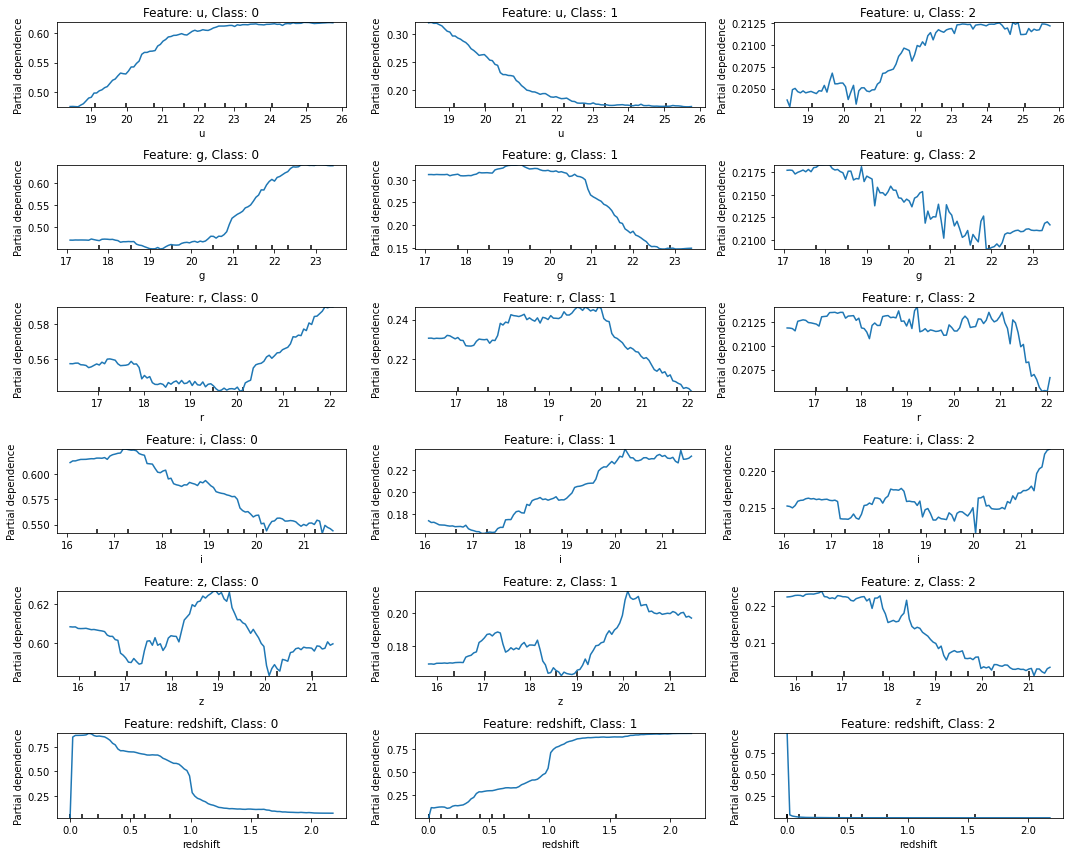

In [31]:
# partial dependence plot

features = ['u', 'g', 'r', 'i', 'z', 'redshift']
num_classes = 3  
# subplots: rows=features, columns=classes
fig, axes = plt.subplots(len(features), num_classes, figsize=(15, 12))

for i, feature in enumerate(features):
    for class_idx in range(num_classes):
        plot_partial_dependence(estimator=rf_model, X=X_test, features=[feature], target=class_idx, ax=axes[i, class_idx])
        axes[i, class_idx].set_title(f'Feature: {feature}, Class: {class_idx}')

plt.tight_layout()
plt.show()

In [32]:
plt.savefig("pdp_plots.png", dpi=300, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

# Shapely Values

In [39]:
#shap values
explainer = shap.Explainer(rf_model, X_train, model_output="probability")
shap_values = explainer(X_test)



100%|===================| 59986/60000 [21:57<00:00]        

NameError: name 'ragne' is not defined

In [47]:
print(shap_values.shape)
print(shap_values[1].shape)
print(X_test.shape)

(20000, 6, 3)
(6, 3)
(20000, 6)


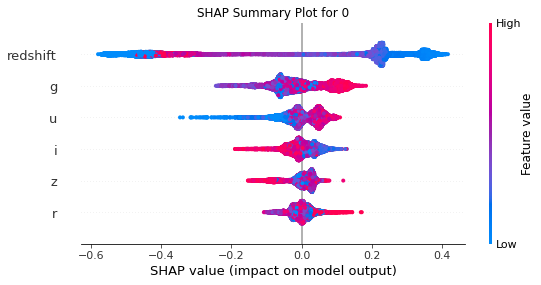

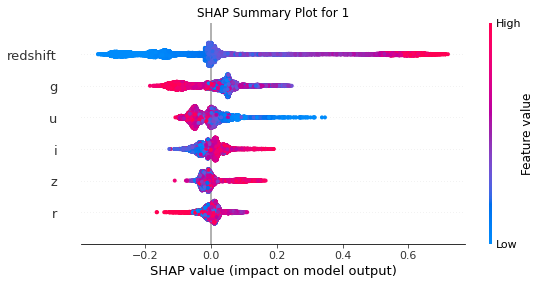

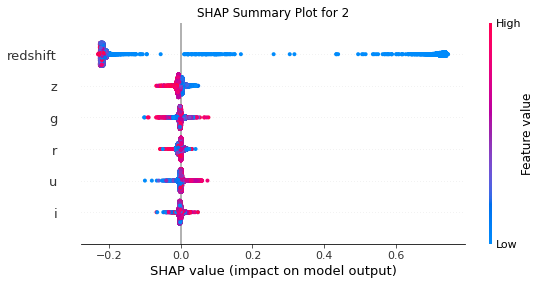

In [50]:
#plots
shap_values_array = shap_values.values
shap_values_array = shap_values_array.transpose((2, 0, 1))  
for i in range (3):
    
    plt.figure() #individual plots
    shap.summary_plot(shap_values_array[i], X_test, feature_names=features, show=False)
    plt.title(f"SHAP Summary Plot for {i}")
    plt.show() #display


# Precision-Recall

0.97785
[[0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [1 0 0]
 [0 0 1]
 [0 0 1]
 [0 1 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [1 0 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [0 0 1]]


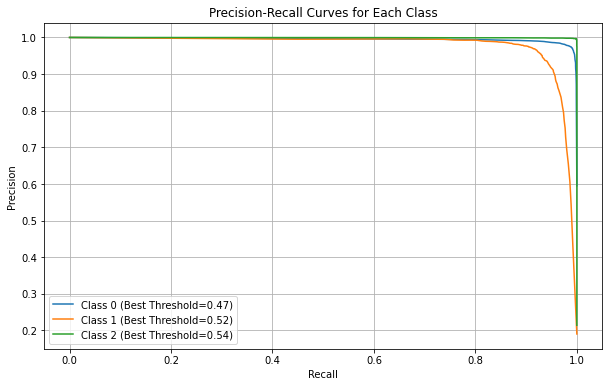

Optimal thresholds for each class: {0: 0.47, 1: 0.52, 2: 0.54}


In [5]:
# raw data Random Forest for Precision_Recall curve

from sklearn.metrics import precision_recall_curve, average_precision_score

## train test split
X = df.drop('Class',axis='columns')
y = np.array(df['Class'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

#array dimensions
y_train = y_train.transpose()
y_test = y_test.transpose()

#random forest
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train)

# Get predicted probabilities
y_proba = rf_model.predict_proba(X_test)  # Shape: (num_samples, num_classes)

print(accuracy_score(y_test, y_pred))


from sklearn.preprocessing import label_binarize
n_classes = 3
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))  # Convert to binary format
print(y_test_bin[:20])

# Plot Precision-Recall Curves for each class
plt.figure(figsize=(10, 6))
thresholds_dict = {}  # Store best thresholds for each class

for i in range(n_classes):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)  # Compute F1-score
    
    # Find the threshold with the best F1-score
    best_threshold = thresholds[np.argmax(f1_scores)]
    thresholds_dict[i] = best_threshold

    # Plot the curve
    plt.plot(recall, precision, label=f'Class {i} (Best Threshold={best_threshold:.2f})')

# Plot formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Class')
plt.legend()
plt.grid()
plt.show()

# Print best thresholds for each class
print("Optimal thresholds for each class:", thresholds_dict)

In [6]:
# Apply the new thresholds
y_pred_adjusted = np.array([np.argmax(probs) if max(probs) > thresholds_dict[np.argmax(probs)] else -1 for probs in y_proba])

# Handle cases where no class meets the threshold
y_pred_adjusted[y_pred_adjusted == -1] = np.random.choice([0, 1, 2])  

# Evaluate results
print(accuracy_score(y_test, y_pred_adjusted))
print(metrics.confusion_matrix(y_pred_adjusted, y_test))
print(classification_report(y_test, y_pred_adjusted))

0.9769
[[11757   298     4]
 [  120  3499     0]
 [   27    13  4282]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     11904
           1       0.97      0.92      0.94      3810
           2       0.99      1.00      0.99      4286

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



# Rest: Hyperparameters, Normalizing, Subsets

In [22]:
#hyperparameter tuning

#hyperparameters
param_grid = {
    'n_estimators': [100, 200, 500], #Number of trees
    'max_depth': [10, 20, 30, None], 
    'min_samples_split': [2, 5, 10], #Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None], 
}

#search
grid_search = GridSearchCV(estimator=rf_model, 
                           param_grid=param_grid, 
                           cv=3, #cross validation
                           verbose=1,
                           n_jobs=-1) 

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

#running random forest with hyperparameters
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train)

y_pred = grid_search.best_estimator_.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_pred, y_test))
print(classification_report(y_pred, y_test))

Fitting 3 folds for each of 324 candidates, totalling 972 fits
{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
0.9772
[[11754   302     4]
 [  135  3508     0]
 [   15     0  4282]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     12060
           1       0.92      0.96      0.94      3643
           2       1.00      1.00      1.00      4297

    accuracy                           0.98     20000
   macro avg       0.97      0.98      0.97     20000
weighted avg       0.98      0.98      0.98     20000



# Normalizing

In [56]:
#normalizing

X = df.drop('Class', axis=1)
y = df['Class']

#normalize features
scaler = preprocessing.MinMaxScaler()  #default range [0, 1]
X_normalized = scaler.fit_transform(X)

#put everything together in a pandas dataframe, list
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)
df_normalized = pd.concat([X_normalized, y.reset_index(drop=True)], axis=1)

print(df_normalized.head(10))
print(df_normalized.describe())

          u         g         r         i         z  redshift  Class
0  0.591347  0.558050  0.535344  0.427665  0.464377  0.091831      0
1  0.632603  0.584423  0.646203  0.515986  0.607035  0.112389      0
2  0.654888  0.576463  0.546218  0.435729  0.472194  0.093170      0
3  0.511384  0.629186  0.596946  0.486717  0.487460  0.134210      0
4  0.387463  0.335579  0.337999  0.287021  0.300043  0.017959      0
5  0.573420  0.608393  0.582279  0.475761  0.502398  0.204328      1
6  0.480763  0.505971  0.562346  0.491292  0.546921  0.084946      1
7  0.516570  0.546034  0.532623  0.441877  0.467223  0.069358      0
8  0.615402  0.561906  0.546246  0.440860  0.472712  0.095423      0
9  0.493476  0.451891  0.473598  0.412337  0.457321  0.001419      2
                  u             g             r             i             z  \
count  99999.000000  99999.000000  99999.000000  99999.000000  99999.000000   
mean       0.508807      0.480163      0.497408      0.424098      0.463126   
std 

In [14]:
# normalized data Random Forest

## train test split
X = df_normalized.drop('Class',axis='columns')
y = np.array(df_normalized['Class'])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

#array dimensions
y_train = y_train.transpose()
y_test = y_test.transpose()

#random forest with normalized data
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_pred, y_test))
print(classification_report(y_pred, y_test))

0.97595
[[11728   299     6]
 [  136  3511     0]
 [   40     0  4280]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     12033
           1       0.92      0.96      0.94      3647
           2       1.00      0.99      0.99      4320

    accuracy                           0.98     20000
   macro avg       0.97      0.98      0.97     20000
weighted avg       0.98      0.98      0.98     20000



# Subsets

In [57]:
#creating a subset of the training data

train, test = train_test_split(df_normalized,test_size=0.2, random_state = 42)

#subset the dataframe
train['Class'] = train['Class'].astype('category')

train['Class_code'] = train['Class'].cat.codes
sub1 = train[train['Class_code'] == train['Class'].cat.categories.get_loc(1)]

#creating a subset of galaxies sub0
n_sub1 = len(sub1)
sub0_all = train[train['Class_code'] == train['Class'].cat.categories.get_loc(0)]
sub0 = sub0_all.sample(n=n_sub1, random_state=42)  

#creating a subset of stars sub2
sub2_all = train[train['Class_code'] == train['Class'].cat.categories.get_loc(2)]
sub2 = sub2_all.sample(n=n_sub1, random_state=42)  

#merge the subsets
sub=pd.concat([sub0, sub1, sub2], axis=0)

sub_shuffle = sub.sample(frac=1, random_state = 42).reset_index(drop=True)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [18]:
#random forest on normalized data with subsets

#train test split
X_train = sub.drop('Class',axis='columns')
X_train = X_train.drop('Class_code',axis='columns')
y_train = np.array(sub['Class'])

X_test = test.drop('Class',axis='columns')
y_test = np.array(test['Class'])

#array dimensions
y_train = y_train.transpose()
y_test = y_test.transpose()

#run random forest on normalized data with subsets
rf_model = RandomForestClassifier()
rf_model = rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(metrics.confusion_matrix(y_pred, y_test))
print(classification_report(y_pred, y_test))

0.97145
[[11536   201     2]
 [  292  3609     0]
 [   76     0  4284]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11739
           1       0.95      0.93      0.94      3901
           2       1.00      0.98      0.99      4360

    accuracy                           0.97     20000
   macro avg       0.97      0.96      0.97     20000
weighted avg       0.97      0.97      0.97     20000



In [59]:
# two binary classifications, Random Forest
## train test split
X = sub.drop('Class',axis='columns')
#X_train = X_train.drop('Class_code',axis='columns')
y = np.array(sub['Class'])
print(X_train.head)

#stars
y_binary1 = (y == 2).astype(int) # stars 1, others 0
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y_binary1,test_size=0.2, random_state = 42)

#array dimensions
y_train1 = y_train1.transpose()
y_test1 = y_test1.transpose()

#fit model for stars
rf_model1 = RandomForestClassifier(random_state=42)
rf_model1.fit(X_train1, y_train1)

y_pred1 = rf_model1.predict(X_test1)


#idneitfy not stars in X (features) and Y (class labels), new train and test data 2
X_train2 = X_train1[y_train1 != 2]
y_train2 = y_train[y_train1 != 2]
X_test2 = X_test1[y_pred1 != 2]  
y_test2 = y_test1[y_pred1 != 2] 

#second binary classifier galaxies and quasars
rf_model2 = RandomForestClassifier(random_state=42)
rf_model2.fit(X_train2, y_train2)

y_pred2 = rf_model2.predict(X_test2)

# Combine predictions
#final_predictions = np.full_like(y_test1, fill_value=2)  # Default all to Class 2
#final_predictions[y_pred1 == 0] = y_pred2  # Assign Class 0 or 1 for non-Class 2 samples
final_predictions = np.where(y_pred1 == 1, 2, y_pred2)


print(accuracy_score(y_test1, final_predictions))
print(metrics.confusion_matrix(final_predictions, y_test1))
print(classification_report(final_predictions, y_test1))

<bound method NDFrame.head of               u         g         r         i         z  redshift
64470  22.56362  22.29045  20.13317  19.37979  18.81932  0.388563
45557  25.75409  23.52925  21.99705  20.80995  19.85379  0.892507
27614  26.10760  21.77694  20.32209  19.48528  19.08093  0.477062
13568  20.25937  18.53387  17.58141  17.16960  16.85448  0.108840
92727  22.03892  21.46501  21.32925  21.26120  21.17124 -0.001039
...         ...       ...       ...       ...       ...       ...
6265   20.82854  20.32382  20.25718  20.39426  20.36549  2.412806
54886  18.93209  16.96611  16.05940  15.64639  15.30356  0.081128
76820  23.95684  21.37612  19.75149  18.49137  17.77083  0.000253
860    17.79224  16.47265  15.84970  15.59104  15.46414  0.000000
15795  24.93142  21.08619  19.28560  18.66209  18.36053  0.352529

[79999 rows x 6 columns]>


IndexError: boolean index did not match indexed array along dimension 0; dimension is 79999 but corresponding boolean dimension is 36362